# Networks: structure, evolution & processes
**Internet Analytics - Lab 2**

---

**Group:** *O.*

**Names:**

* *Argelaguet Franquelo, Pau*
* *du Bois de Dunilac, Vivien*

---

#### Instructions

*This is a template for part 4 of the lab. Clearly write your answers, comments and interpretations in Markodown cells. Don't forget that you can add $\LaTeX$ equations in these cells. Feel free to add or remove any cell.*

*Please properly comment your code. Code readability will be considered for grading. To avoid long cells of codes in the notebook, you can also embed long python functions and classes in a separate module. Don’t forget to hand in your module if that is the case. In multiple exercises, you are required to come up with your own method to solve various problems. Be creative and clearly motivate and explain your methods. Creativity and clarity will be considered for grading.*

In [1]:
%matplotlib inline
import networkx as nx
from networkx.readwrite import json_graph
import matplotlib.pyplot as plt
import collections
import operator
import random
import numpy as np
import json
from random import choice
import epidemics_helper

---

## 2.4 PageRank

### 2.4.1 Random Surfer Model

#### Exercise 2.12

In [2]:
def random_walk(G, n_steps):
    r_dict = {}
    for n in G.nodes():
        r_dict[n] = 0
    current_node = choice(list(G.nodes()))
    r_dict[current_node] = r_dict.get(current_node, 0)+1
    for i in range(n_steps - 1):
        if(len(G[current_node]) > 0):
            current_node = choice(list(G[current_node]))
        r_dict[current_node] = r_dict.get(current_node, 0)+1
        
    for k, v in r_dict.items():
        r_dict[k] = v/n_steps
        
    return r_dict

In [3]:
graph_abs = nx.read_adjlist("../data/absorbing.graph", nodetype=int, create_using=nx.DiGraph())
print(random_walk(graph_abs, 10000))

{0: 0.0001, 1: 0.9997, 4: 0.0, 2: 0.0001, 3: 0.0001}


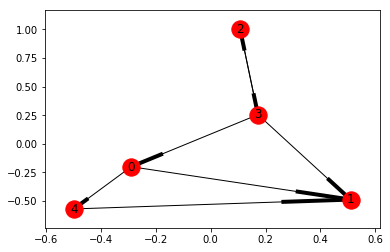

In [4]:
nx.draw_networkx(graph_abs)

The simple random walker fails on this graph because node 1 has no outgoing edges. Once the walker reaches it, it becomes
stuck and only increases its score.

In [5]:
graph_comp = nx.read_adjlist("../data/components.graph", nodetype=int, create_using=nx.DiGraph())
print(random_walk(graph_comp, 10000))

{0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.2848, 5: 0.1456, 6: 0.2848, 7: 0.2848}


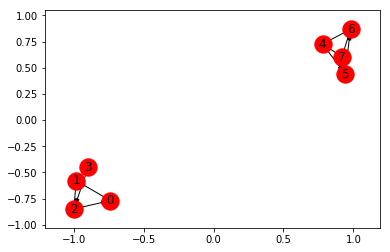

In [6]:
nx.draw_networkx(graph_comp)

The simple random walker fails on this graph because it contains two disjoint subgraphs and the walker will never
change from one to the other. This means that the score of one the subgraphs will always be 0.

#### Exercise 2.13

In [7]:
def modified_walk(G, n_steps, jump_thresh):
    r_dict = {}
    for n in G.nodes():
        r_dict[n] = 0
    current_node = choice(list(G.nodes()))
    r_dict[current_node] = r_dict.get(current_node, 0)+1
    for i in range(n_steps - 1):
        if(len(G[current_node]) > 0):
            current_node = choice(list(G[current_node]))
        else:
            current_node = choice(list(G.nodes()))
            
        if(random.randint(0, 100) > jump_thresh):
            current_node = choice(list(G.nodes()))
        r_dict[current_node] = r_dict.get(current_node, 0)+1
        
    for k, v in r_dict.items():
        r_dict[k] = v/n_steps
        
    return r_dict

In [8]:
graph_abs = nx.read_adjlist("../data/absorbing.graph", nodetype=int, create_using=nx.DiGraph())
print(modified_walk(graph_abs, 10000, 15))

{0: 0.1812, 1: 0.2299, 4: 0.1928, 2: 0.182, 3: 0.2141}


In [9]:
graph_comp = nx.read_adjlist("../data/components.graph", nodetype=int, create_using=nx.DiGraph())
print(modified_walk(graph_comp, 10000, 15))

{0: 0.1304, 1: 0.1246, 2: 0.1281, 3: 0.1162, 4: 0.1244, 5: 0.1178, 6: 0.1352, 7: 0.1233}


---

### 2.4.2 Power Iteration Method

#### Exercise 2.14: Power Iteration method

In [10]:
def power_iteration(G, n_steps, theta):
    n = G.number_of_nodes()
    H = np.zeros((n, n))
    for i in range(n):
        if(len(G[i]) > 0):
            H[i] = np.ones(n) * ((1-theta)/n)
            for node in G[i]:
                H[i,node] += theta/len(G[i])
        else:
            H[i] = np.ones(n) * (1/n)
    
    dist = np.ones(n) * (1/n)
    for i in range(n_steps):
        dist = dist @ H
        
    return dist

In [11]:
print(power_iteration(graph_comp, 100, 0.15))

[ 0.12619764  0.12517965  0.13298424  0.11563847  0.12517965  0.11563847
  0.13298424  0.12619764]


In [12]:
print(power_iteration(graph_abs, 100, 0.15))

[ 0.18714284  0.22981809  0.18714284  0.20496597  0.19093026]


In [13]:
graph_wiki = nx.read_adjlist("../data/wikipedia.graph", nodetype=int, create_using=nx.DiGraph())
a = power_iteration(graph_wiki, 100, 0.15)
print(a.shape)

(5540,)


In [14]:
idx = (-a).argsort()
print(idx)

[5210 5201 1811 ..., 5079 3892 3636]


In [15]:
def import_tsv(filename):
    d={}
    with open(filename, errors='ignore') as f:
        c = 0
        for line in f:
            if(c > 0):
                (key, value)=line.split('\t')
                d[int(key)]=value
            c += 1
    return d

In [16]:
pages = import_tsv("../data/wikipedia_titles.tsv")
rank = 1
for i in idx[:10]:
    print(rank, pages[i], a[i])
    rank += 1

1 United States
 0.00184639029016
2 United Kingdom
 0.00129924055816
3 England
 0.00116543729941
4 France
 0.00107661033528
5 Europe
 0.00104183672692
6 Biological classification
 0.000983248347936
7 Animal
 0.000893541510012
8 World War II
 0.000860589469664
9 London
 0.000847525595923
10 Germany
 0.00084639427413


---

### 2.4.3 Gaming the system *(Bonus)*

#### Exercise 2.15 *(Bonus)*

In [17]:
math_id = 2463
print("Score of {}: {}".format(pages[math_id], a[math_id]))

Score of History of mathematics
: 0.0001600088309732059


In [18]:
graph_wiki_modif = graph_wiki.copy()
initial_size = len(graph_wiki)
print("Initial size:", initial_size)

MAX_NODES = 300
for i in range(MAX_NODES):
    nid = initial_size + i
    graph_wiki_modif.add_node(nid)
    graph_wiki_modif.add_edge(nid, math_id)
    
print("Final size:", len(graph_wiki_modif))

Initial size: 5540
Final size: 5840


In [19]:
b = power_iteration(graph_wiki_modif, 100, 0.15)
idxb = (-b).argsort()
print("Score of {}: {}".format(pages[math_id], b[math_id]))

Score of History of mathematics
: 0.006702977097994818


In [20]:
rank = 1
for i in idxb[:10]:
    print(rank, pages[i], b[i])
    rank += 1

1 History of mathematics
 0.00670297709799
2 United States
 0.00175193440832
3 United Kingdom
 0.00123288382518
4 England
 0.00111379138978
5 France
 0.00102987508653
6 Europe
 0.000988936098682
7 Biological classification
 0.000932736286894
8 Animal
 0.000847661835252
9 World War II
 0.000816703650356
10 London
 0.000804047223545


To increase the rank of a given node with the limitation of adding at most 300 nodes, we can use the naive algorithm of adding those 300 nodes and then adding an edge from each one of them to the target node. Sice the network we're working with is realively small, we can see how easily the score of the target node becomes the highest by far of the network (from 0.00016 to 0.006).